In [2]:
from IPython.display import Image, SVG
import matplotlib.pyplot as plt

import numpy as np
import keras
from keras.datasets import mnist
from keras.models import Model, Sequential, load_model
from keras.layers import Input, Dense, Conv2D,MaxPooling2D, UpSampling1D, ZeroPadding1D, Flatten, Reshape, Conv1D, BatchNormalization, Activation
from keras import regularizers
from sklearn.model_selection import train_test_split

In [3]:
q001_data_raw = np.load('/data1/ryan/train-files/train_q001_bot.npy')
q003_data_raw = np.load('/data1/ryan/train-files/train_q003_bot.npy')
q076_data_raw = np.load('/data1/ryan/train-files/train_q076_bot.npy')
q103_data_raw = np.load('/data1/ryan/train-files/train_q103_bot.npy')

#don't normalize over the whole quench, normalize each image
q001_data = q001_data_raw
q003_data = q003_data_raw
q076_data = q076_data_raw
q103_data = q103_data_raw

#it's not pretty but it works
# for i, im in enumerate(q001_data_raw):
#     q001_data[i,:] = q001_data_raw[i,:] / np.max(q001_data_raw[i,:])

# for i, im in enumerate(q003_data_raw):
#     q003_data[i,:] = q003_data_raw[i,:] / np.max(q003_data_raw[i,:])
    
# for i, im in enumerate(q076_data_raw):
#     q076_data[i,:] = q076_data_raw[i,:] / np.max(q076_data_raw[i,:])
    
# for i, im in enumerate(q103_data_raw):
#     q103_data[i,:] = q103_data_raw[i,:] / np.max(q103_data_raw[i,:])

In [4]:
#we shuffle in the training so it's ok
#i guess we lose some in the shuffle?
#shuffle by default
qall_data = np.concatenate((q001_data, q003_data, q076_data, q103_data), axis=0)
print(qall_data.shape)
data_mod = np.empty((qall_data.shape[0], qall_data.shape[1], 1))
data_mod[:, :, 0] = qall_data

x_train_temp, x_test_temp = train_test_split(qall_data, random_state=42)
print(x_train_temp.shape)
print(x_test_temp.shape)

x_train = np.empty((x_train_temp.shape[0], x_train_temp.shape[1], 1))
x_test = np.empty((x_test_temp.shape[0], x_test_temp.shape[1], 1))
x_train[:, :, 0] = x_train_temp
x_test[:, :, 0] = x_test_temp

print(x_train.shape)
print(x_test.shape)

(22820, 2000)
(17115, 2000)
(5705, 2000)
(17115, 2000, 1)
(5705, 2000, 1)


In [5]:
input_dim_1 = x_train.shape[1]
input_dim_2 = x_train.shape[2]
encoding_dim = 40

compression_factor = float(input_dim_1) / encoding_dim
print("Compression factor: %s" % compression_factor)

def Conv1DTranspose(input_tensor, filters, kernel_size, stride, padding):
    x = Lambda(lambda x: K.expand_dims(x, axis=2))(input_tensor)
    x = Conv2DTranspose(filters=filters, kernel_size=(kernel_size, 1), strides=(strides, 1), padding=padding)(x)
    x = Lambda(lambda x: K.squeeze(x, axis=2))(x)
    return x

autoencoder = Sequential()

# Encoder Layers
autoencoder.add(ZeroPadding1D(3, input_shape=(input_dim_1, input_dim_2)))
autoencoder.add(Conv1D(filters=512, kernel_size=10, strides=5))
autoencoder.add(BatchNormalization())
autoencoder.add(Activation('relu'))
autoencoder.add(ZeroPadding1D(2))
autoencoder.add(Conv1D(filters=512, kernel_size=8, strides=5))
autoencoder.add(BatchNormalization())
autoencoder.add(Activation('relu'))
autoencoder.add(ZeroPadding1D(1))
autoencoder.add(Conv1D(filters=512, kernel_size=4, strides=2))
autoencoder.add(BatchNormalization())
autoencoder.add(Activation('relu'))
autoencoder.add(ZeroPadding1D(1))
autoencoder.add(Conv1D(filters=512, kernel_size=3, strides=1))
autoencoder.add(BatchNormalization())
autoencoder.add(Activation('relu'))
autoencoder.add(ZeroPadding1D(1))
autoencoder.add(Conv1D(filters=512, kernel_size=3, strides=1))
autoencoder.add(BatchNormalization())
autoencoder.add(Activation('relu'))

# Decoder Layers
autoencoder.add(UpSampling1D(1))
autoencoder.add(Conv1D(filters=512, kernel_size=3, strides=1, padding='same'))
autoencoder.add(BatchNormalization())
autoencoder.add(Activation('relu'))
autoencoder.add(UpSampling1D(1))
autoencoder.add(Conv1D(filters=512, kernel_size=3, strides=1, padding='same'))
autoencoder.add(BatchNormalization())
autoencoder.add(Activation('relu'))
autoencoder.add(UpSampling1D(2))
autoencoder.add(Conv1D(filters=512, kernel_size=4, strides=1, padding='same'))
autoencoder.add(BatchNormalization())
autoencoder.add(Activation('relu'))
autoencoder.add(UpSampling1D(5))
autoencoder.add(Conv1D(filters=512, kernel_size=8, strides=1, padding='same'))
autoencoder.add(BatchNormalization())
autoencoder.add(Activation('relu'))
autoencoder.add(UpSampling1D(5))
autoencoder.add(Conv1D(filters=1, kernel_size=10, strides=1, padding='same'))
autoencoder.add(Activation('tanh'))

autoencoder.summary()

Compression factor: 50.0
Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding1d_1 (ZeroPaddin (None, 2006, 1)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 400, 512)          5632      
_________________________________________________________________
batch_normalization_1 (Batch (None, 400, 512)          2048      
_________________________________________________________________
activation_1 (Activation)    (None, 400, 512)          0         
_________________________________________________________________
zero_padding1d_2 (ZeroPaddin (None, 404, 512)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 80, 512)           2097664   
_____________________________________________

In [6]:
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('activation_5').output)
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding1d_1_input (Inpu (None, 2000, 1)           0         
_________________________________________________________________
zero_padding1d_1 (ZeroPaddin (None, 2006, 1)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 400, 512)          5632      
_________________________________________________________________
batch_normalization_1 (Batch (None, 400, 512)          2048      
_________________________________________________________________
activation_1 (Activation)    (None, 400, 512)          0         
_________________________________________________________________
zero_padding1d_2 (ZeroPaddin (None, 404, 512)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 80, 512)           2097664   
__________

In [7]:
from keras.optimizers import Adam
import keras.backend as K

autoencoder.compile(optimizer=Adam(lr=0.0001), loss='mean_squared_error')

print(K.eval(autoencoder.optimizer.lr))

history = autoencoder.fit(x_train, x_train,
                epochs=20,
                batch_size=64,
                validation_data=(x_test, x_test))

1e-04
Instructions for updating:
Use tf.cast instead.
Train on 17115 samples, validate on 5705 samples
Epoch 1/20
17115/17115 [==============================] - 39s 2ms/step - loss: 0.0120 - val_loss: 0.0028
Epoch 2/20
17115/17115 [==============================] - 35s 2ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 3/20
17115/17115 [==============================] - 35s 2ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 4/20
17115/17115 [==============================] - 35s 2ms/step - loss: 0.0015 - val_loss: 0.0025
Epoch 5/20
17115/17115 [==============================] - 35s 2ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 6/20
17115/17115 [==============================] - 35s 2ms/step - loss: 0.0012 - val_loss: 0.0021
Epoch 7/20
17115/17115 [==============================] - 35s 2ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 8/20
17115/17115 [==============================] - 35s 2ms/step - loss: 0.0011 - val_loss: 0.0036
Epoch 9/20
17115/17115 [==============================] -

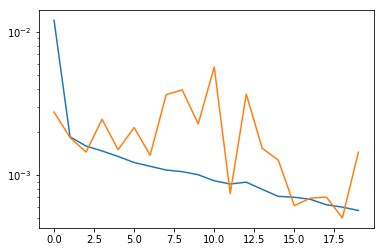

In [8]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.yscale('log')

In [9]:
autoencoder.save('case_3_autoencoder_conv.h5')

In [5]:
autoencoder = load_model('case_3_autoencoder_conv.h5')

encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('activation_5').output)
encoder.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding1d_1_input (Inpu (None, 2000, 1)           0         
_________________________________________________________________
zero_padding1d_1 (ZeroPaddin (None, 2006, 1)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 400, 64)           704       
_________________________________________________________________
batch_normalization_1 (Batch (None, 400, 64)           256       
_________________________________________________________________
activation_1 (Activation)    (None, 400, 64)           0         
_________________________________________________________________
zero_padding1d_2 (ZeroPaddin (None, 404, 64)           0         
______________________

(5705, 2000, 1)
(5705, 2000, 1)


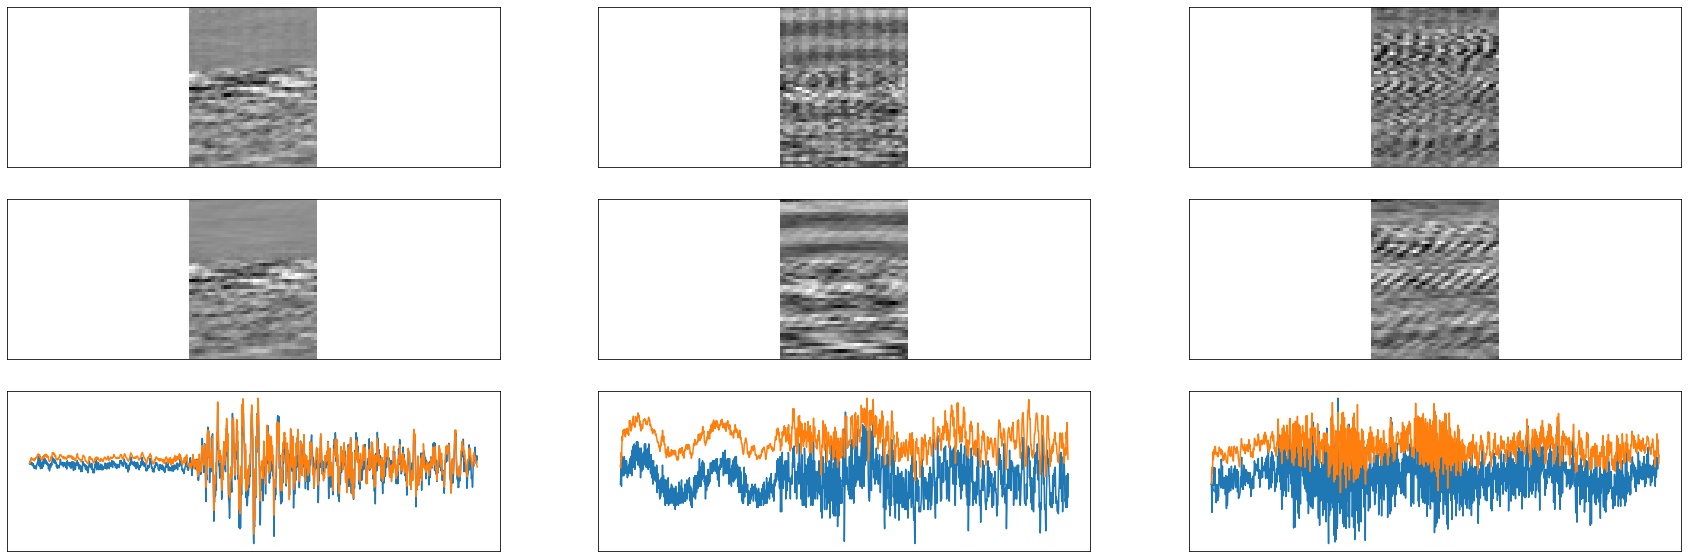

In [14]:
num_images = 3
random_test_images = np.random.randint(x_test.shape[0], size=num_images)

encoded_imgs = encoder.predict(x_test)
decoded_imgs = autoencoder.predict(x_test)

print(x_test.shape)
print(decoded_imgs.shape)

plt.figure(figsize=(30, 10))
#scalograms are 256 by 512

for i, image_idx in enumerate(random_test_images):
    # plot original image
    ax = plt.subplot(3, num_images, i + 1)
    plt.imshow(x_test[image_idx].reshape(50, 40))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.axis('equal')
    
    # plot encoded image
#     ax = plt.subplot(3, num_images, num_images + i + 1)
#     plt.imshow(encoded_imgs[image_idx, :, 256].reshape(8, 5))
#     plt.gray()
#     ax.get_xaxis().set_visible(False)
#     ax.get_yaxis().set_visible(False)
#     plt.axis('equal')

    # plot reconstructed image
    ax = plt.subplot(3, num_images, num_images + i + 1)
    plt.imshow(decoded_imgs[image_idx].reshape(50, 40))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.axis('equal')
    
    ax = plt.subplot(3, num_images, 2*num_images + i + 1)
    plt.plot(x_test[image_idx, :, 0])
    plt.plot(decoded_imgs[image_idx, :, 0])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
#     ax = plt.subplot(3, num_images, 2*num_images + i + 1)
#     plt.plot(decoded_imgs[image_idx, :, 0])
#     ax.get_xaxis().set_visible(False)
#     ax.get_yaxis().set_visible(False)
    
#     ax = plt.subplot(3, num_images, 3*num_images + i + 1)
#     plt.plot(decoded_imgs[image_idx, :, 0])
#     ax.get_xaxis().set_visible(False)
#     ax.get_yaxis().set_visible(False)
#     plt.axis('equal')
plt.show()

In [13]:
#Try pca on encoded images to cluster the embedded space
from sklearn.decomposition import PCA

encoded_all = encoder.predict(data_mod)
encoded = encoded_all[:, :,384]
print(encoded_all.shape)

pca = PCA(n_components=2)
#need to flatten i guess?
img_pca = pca.fit_transform(encoded)

#boundary 1
boundary1 = q001_data.shape[0]
#boundary 2
boundary2 = boundary1 + q003_data.shape[0]
#boundary 3
boundary3 = boundary2 + q076_data.shape[0]

color_key=['red','orange','green','blue']
color_label=[]
for i in range(qall_data.shape[0]):
    if i <= boundary1:
        color_label.append(color_key[0])
    elif boundary1 <= i < boundary2:
        color_label.append(color_key[1])
    elif boundary2 <= i < boundary3: 
        color_label.append(color_key[2])
    else:
        color_label.append(color_key[3])
        
print(len(color_label))

(22820, 40, 512)
22820


In [8]:
print('The first component:', pca.explained_variance_ratio_[0])
print('The second component:', pca.explained_variance_ratio_[1])
print('They don\'t take much of the variance...')

The first component: 0.6034125481102532
The second component: 0.21537362474046198
They don't take much of the variance...


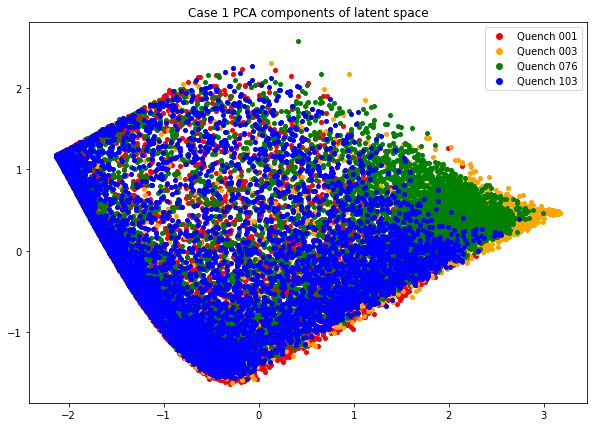

In [9]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

msize = 16

# hack the legend together
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Quench 001',
                          markerfacecolor='red', markersize=8),
                   Line2D([0], [0], marker='o', color='w', label='Quench 003',
                          markerfacecolor='orange', markersize=8),
                   Line2D([0], [0], marker='o', color='w', label='Quench 076',
                          markerfacecolor='green', markersize=8),
                   Line2D([0], [0], marker='o', color='w', label='Quench 103',
                          markerfacecolor='blue', markersize=8)]

# Create the figure and add our hacked legend
plt.figure(figsize=(10, 7))
for i in range(qall_data.shape[0]):
    plt.scatter(img_pca[i,0],img_pca[i,1], s=msize, color=color_label[i])
plt.title('Case 1 PCA components of latent space')
plt.legend(handles=legend_elements)
plt.show()

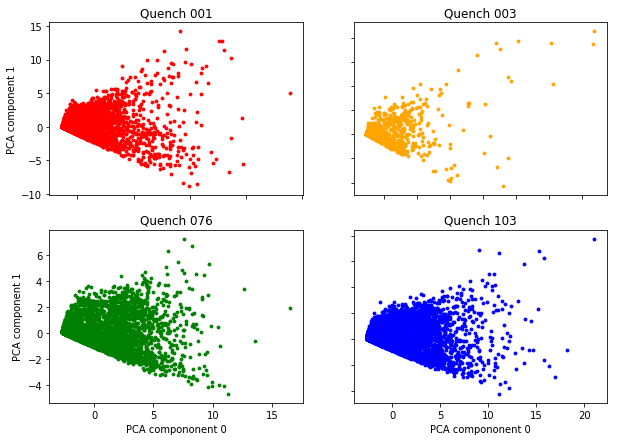

In [14]:
msize = 8

fig, axs = plt.subplots(2, 2)
fig.set_size_inches(10,7)
for i in range(qall_data.shape[0]):
    if color_label[i] == 'red':
        axs[0, 0].scatter(img_pca[i,0],img_pca[i,1], color=color_label[i], s=msize)
        axs[0, 0].set_title('Quench 001')
    elif color_label[i] == 'orange':
        axs[0, 1].scatter(img_pca[i,0],img_pca[i,1], color=color_label[i], s=msize)
        axs[0, 1].set_title('Quench 003')
    elif color_label[i] == 'green':
        axs[1, 0].scatter(img_pca[i,0],img_pca[i,1], color=color_label[i], s=msize)
        axs[1, 0].set_title('Quench 076')
    else:
        axs[1, 1].scatter(img_pca[i,0],img_pca[i,1], color=color_label[i], s=msize)
        axs[1, 1].set_title('Quench 103')

for ax in axs.flat:
    ax.set(xlabel='PCA compononent 0', ylabel='PCA component 1')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

In [23]:
#ok try TSNE for dimensionality reduction instead
from sklearn.manifold import TSNE

perplexity = 30

#if time permits try other complexities

tsne = TSNE(perplexity=perplexity, n_components=2, init='pca', n_iter=1000, random_state=2157)
q_tsne_array = tsne.fit_transform(encoded)

(22820, 2)


<Figure size 720x504 with 0 Axes>

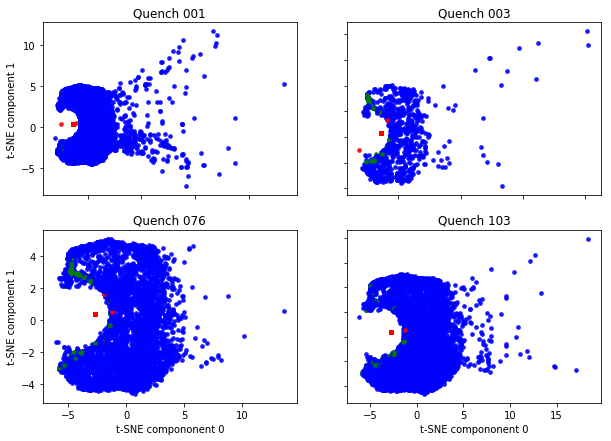

In [25]:
print(q_tsne_array.shape)

plt.figure(figsize=(10, 7))
lw=2
alpha=0.8

#to do this we need a quench_answers_array [0 to 3]
q001_ones = np.zeros(len(q001_data))
q003_ones = np.ones(len(q003_data))*1
q076_ones = np.ones(len(q076_data))*2
q103_ones = np.ones(len(q103_data))*3
q_answers_array = np.concatenate((q001_ones, q003_ones, q076_ones, q103_ones))
    
fig, axs = plt.subplots(2, 2)
# fig = plt.figure()
# axs = fig.add_subplot(111, projection='3d')
fig.set_size_inches(10,7)
for i in range(qall_data.shape[0]):
    if color_label[i] == 'red':
        if clustering.labels_[i] == 42:
            axs[0, 0].scatter(q_tsne_array[i,0],q_tsne_array[i,1], color='r', s=msize, lw=lw, alpha=alpha, label=q_answers_array)
        elif clustering.labels_[i] == -1:
            axs[0, 0].scatter(q_tsne_array[i,0],q_tsne_array[i,1], color='b', s=msize, lw=lw, alpha=alpha, label=q_answers_array)
        else:
            axs[0, 0].scatter(q_tsne_array[i,0],q_tsne_array[i,1], color='g', s=msize, lw=lw, alpha=alpha, label=q_answers_array)
        axs[0, 0].set_title('Quench 001')
    elif color_label[i] == 'orange':
        if clustering.labels_[i] == 42:
            axs[0, 1].scatter(q_tsne_array[i,0],q_tsne_array[i,1], color='r', s=msize, lw=lw, alpha=alpha, label=q_answers_array)
        elif clustering.labels_[i] == -1:
            axs[0, 1].scatter(q_tsne_array[i,0],q_tsne_array[i,1], color='b', s=msize, lw=lw, alpha=alpha, label=q_answers_array)
        else:
            axs[0, 1].scatter(q_tsne_array[i,0],q_tsne_array[i,1], color='g', s=msize, lw=lw, alpha=alpha, label=q_answers_array)
        axs[0, 1].set_title('Quench 003')
    elif color_label[i] == 'green':
        if clustering.labels_[i] == 42:
            axs[1, 0].scatter(q_tsne_array[i,0],q_tsne_array[i,1], color='r', s=msize, lw=lw, alpha=alpha, label=q_answers_array)
        elif clustering.labels_[i] == -1:
            axs[1, 0].scatter(q_tsne_array[i,0],q_tsne_array[i,1], color='b', s=msize, lw=lw, alpha=alpha, label=q_answers_array)
        else:
            axs[1, 0].scatter(q_tsne_array[i,0],q_tsne_array[i,1], color='g', s=msize, lw=lw, alpha=alpha, label=q_answers_array)
        axs[1, 0].set_title('Quench 076')
    else:
        if clustering.labels_[i] == 42:
            axs[1, 1].scatter(q_tsne_array[i,0],q_tsne_array[i,1], color='r', s=msize, lw=lw, alpha=alpha, label=q_answers_array)
        elif clustering.labels_[i] == -1:
            axs[1, 1].scatter(q_tsne_array[i,0],q_tsne_array[i,1], color='b', s=msize, lw=lw, alpha=alpha, label=q_answers_array)
        else:
            axs[1, 1].scatter(q_tsne_array[i,0],q_tsne_array[i,1], color='g', s=msize, lw=lw, alpha=alpha, label=q_answers_array)
        axs[1, 1].set_title('Quench 103')

for ax in axs.flat:
    ax.set(xlabel='t-SNE compononent 0', ylabel='t-SNE component 1')

# plt.legend(loc='best', shadow=False, scatterpoints=1)

# axs.set_xlabel('PCA compononent 0')
# axs.set_ylabel('PCA compononent 1')
# axs.set_zlabel('PCA compononent 2')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

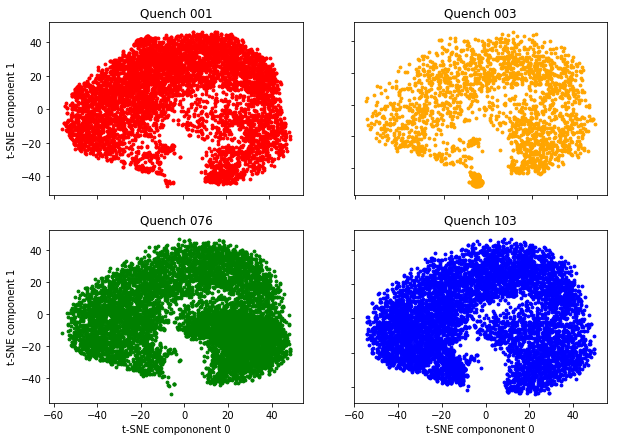

In [19]:
# Plot different t-SNE subplots
msize = 8

fig, axs = plt.subplots(2, 2)
fig.set_size_inches(10,7)
for i in range(qall_data.shape[0]):
    if color_label[i] == 'red':
        axs[0, 0].scatter(q_tsne_array[i,0],q_tsne_array[i,1], color=color_label[i], s=msize)
        axs[0, 0].set_title('Quench 001')
    elif color_label[i] == 'orange':
        axs[0, 1].scatter(q_tsne_array[i,0],q_tsne_array[i,1], color=color_label[i], s=msize)
        axs[0, 1].set_title('Quench 003')
    elif color_label[i] == 'green':
        axs[1, 0].scatter(q_tsne_array[i,0],q_tsne_array[i,1], color=color_label[i], s=msize)
        axs[1, 0].set_title('Quench 076')
    else:
        axs[1, 1].scatter(q_tsne_array[i,0],q_tsne_array[i,1], color=color_label[i], s=msize)
        axs[1, 1].set_title('Quench 103')

for ax in axs.flat:
    ax.set(xlabel='t-SNE compononent 0', ylabel='t-SNE component 1')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

In [20]:
# Using different perplexities
from sklearn.manifold import TSNE

perplexity = 20

#if time permits try other complexities

tsne = TSNE(perplexity=perplexity, n_components=2, init='pca', n_iter=1000, random_state=2157)
q_tsne_array = tsne.fit_transform(encoded)

(22820, 2)


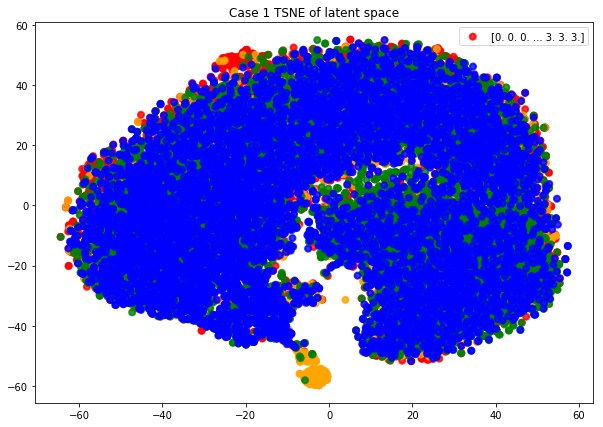

In [21]:
print(q_tsne_array.shape)

plt.figure(figsize=(10, 7))
lw=2
alpha=0.8

#to do this we need a quench_answers_array [0 to 3]
q001_ones = np.zeros(len(q001_data))
q003_ones = np.ones(len(q003_data))*1
q076_ones = np.ones(len(q076_data))*2
q103_ones = np.ones(len(q103_data))*3
q_answers_array = np.concatenate((q001_ones, q003_ones, q076_ones, q103_ones))
    
plt.scatter(q_tsne_array[:,0],q_tsne_array[:,1],color=color_label, lw=lw, alpha=alpha, label=q_answers_array)
plt.legend(loc='best', shadow=False, scatterpoints=1)
#plt.ylim(-1,1)
#plt.xlim(-1,1)
plt.title('Case 1 TSNE of latent space')
plt.show()

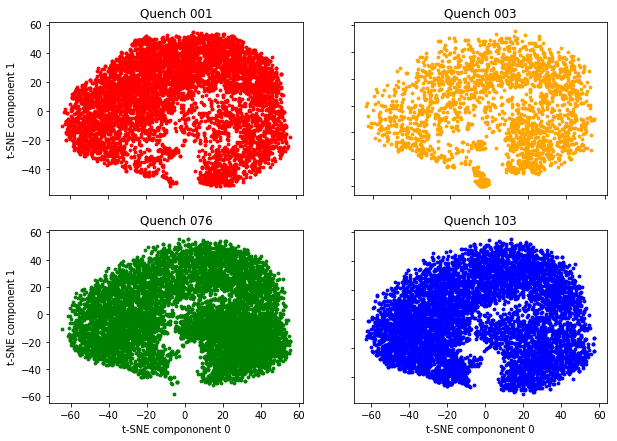

In [22]:
# Plot different t-SNE subplots
msize = 8

fig, axs = plt.subplots(2, 2)
fig.set_size_inches(10,7)
for i in range(qall_data.shape[0]):
    if color_label[i] == 'red':
        axs[0, 0].scatter(q_tsne_array[i,0],q_tsne_array[i,1], color=color_label[i], s=msize)
        axs[0, 0].set_title('Quench 001')
    elif color_label[i] == 'orange':
        axs[0, 1].scatter(q_tsne_array[i,0],q_tsne_array[i,1], color=color_label[i], s=msize)
        axs[0, 1].set_title('Quench 003')
    elif color_label[i] == 'green':
        axs[1, 0].scatter(q_tsne_array[i,0],q_tsne_array[i,1], color=color_label[i], s=msize)
        axs[1, 0].set_title('Quench 076')
    else:
        axs[1, 1].scatter(q_tsne_array[i,0],q_tsne_array[i,1], color=color_label[i], s=msize)
        axs[1, 1].set_title('Quench 103')

for ax in axs.flat:
    ax.set(xlabel='t-SNE compononent 0', ylabel='t-SNE component 1')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

In [23]:
# Using different perplexities
from sklearn.manifold import TSNE

perplexity = 40

#if time permits try other complexities

tsne = TSNE(perplexity=perplexity, n_components=2, init='pca', n_iter=1000, random_state=2157)
q_tsne_array = tsne.fit_transform(encoded)

(22820, 2)


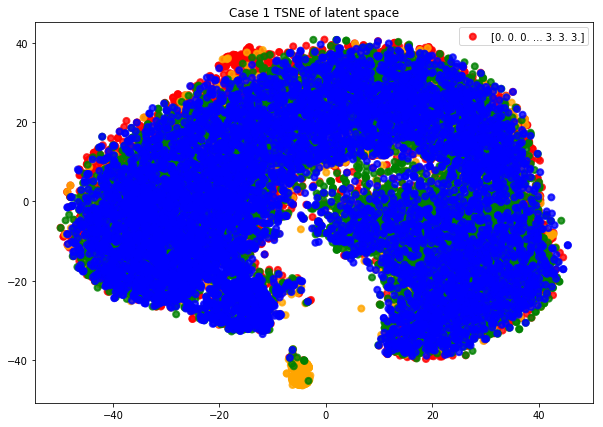

In [24]:
print(q_tsne_array.shape)

plt.figure(figsize=(10, 7))
lw=2
alpha=0.8

#to do this we need a quench_answers_array [0 to 3]
q001_ones = np.zeros(len(q001_data))
q003_ones = np.ones(len(q003_data))*1
q076_ones = np.ones(len(q076_data))*2
q103_ones = np.ones(len(q103_data))*3
q_answers_array = np.concatenate((q001_ones, q003_ones, q076_ones, q103_ones))
    
plt.scatter(q_tsne_array[:,0],q_tsne_array[:,1],color=color_label, lw=lw, alpha=alpha, label=q_answers_array)
plt.legend(loc='best', shadow=False, scatterpoints=1)
#plt.ylim(-1,1)
#plt.xlim(-1,1)
plt.title('Case 1 TSNE of latent space')
plt.show()

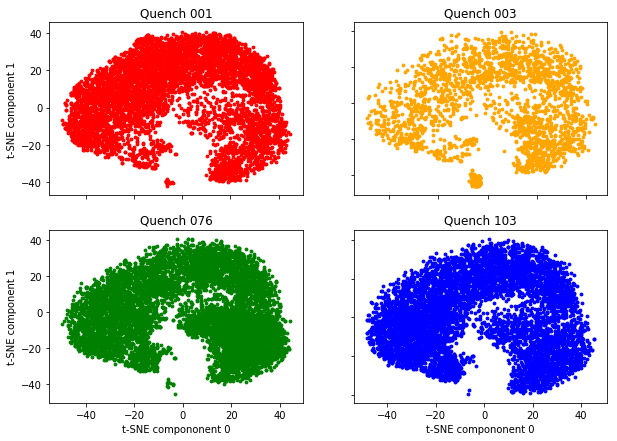

In [25]:
# Plot different t-SNE subplots
msize = 8

fig, axs = plt.subplots(2, 2)
fig.set_size_inches(10,7)
for i in range(qall_data.shape[0]):
    if color_label[i] == 'red':
        axs[0, 0].scatter(q_tsne_array[i,0],q_tsne_array[i,1], color=color_label[i], s=msize)
        axs[0, 0].set_title('Quench 001')
    elif color_label[i] == 'orange':
        axs[0, 1].scatter(q_tsne_array[i,0],q_tsne_array[i,1], color=color_label[i], s=msize)
        axs[0, 1].set_title('Quench 003')
    elif color_label[i] == 'green':
        axs[1, 0].scatter(q_tsne_array[i,0],q_tsne_array[i,1], color=color_label[i], s=msize)
        axs[1, 0].set_title('Quench 076')
    else:
        axs[1, 1].scatter(q_tsne_array[i,0],q_tsne_array[i,1], color=color_label[i], s=msize)
        axs[1, 1].set_title('Quench 103')

for ax in axs.flat:
    ax.set(xlabel='t-SNE compononent 0', ylabel='t-SNE component 1')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

In [26]:
# Using different perplexities
from sklearn.manifold import TSNE

perplexity = 50

#if time permits try other complexities

tsne = TSNE(perplexity=perplexity, n_components=2, init='pca', n_iter=1000, random_state=2157)
q_tsne_array = tsne.fit_transform(encoded)

(22820, 2)


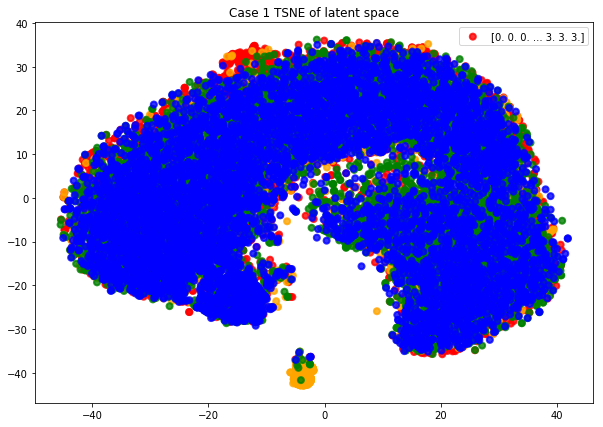

In [27]:
print(q_tsne_array.shape)

plt.figure(figsize=(10, 7))
lw=2
alpha=0.8

#to do this we need a quench_answers_array [0 to 3]
q001_ones = np.zeros(len(q001_data))
q003_ones = np.ones(len(q003_data))*1
q076_ones = np.ones(len(q076_data))*2
q103_ones = np.ones(len(q103_data))*3
q_answers_array = np.concatenate((q001_ones, q003_ones, q076_ones, q103_ones))
    
plt.scatter(q_tsne_array[:,0],q_tsne_array[:,1],color=color_label, lw=lw, alpha=alpha, label=q_answers_array)
plt.legend(loc='best', shadow=False, scatterpoints=1)
#plt.ylim(-1,1)
#plt.xlim(-1,1)
plt.title('Case 1 TSNE of latent space')
plt.show()

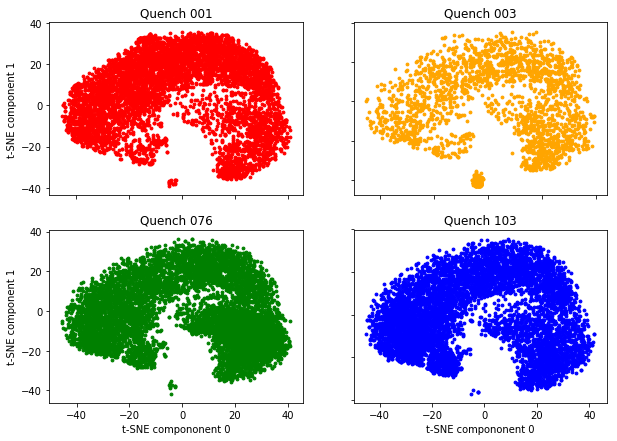

In [28]:
# Plot different t-SNE subplots
msize = 8

fig, axs = plt.subplots(2, 2)
fig.set_size_inches(10,7)
for i in range(qall_data.shape[0]):
    if color_label[i] == 'red':
        axs[0, 0].scatter(q_tsne_array[i,0],q_tsne_array[i,1], color=color_label[i], s=msize)
        axs[0, 0].set_title('Quench 001')
    elif color_label[i] == 'orange':
        axs[0, 1].scatter(q_tsne_array[i,0],q_tsne_array[i,1], color=color_label[i], s=msize)
        axs[0, 1].set_title('Quench 003')
    elif color_label[i] == 'green':
        axs[1, 0].scatter(q_tsne_array[i,0],q_tsne_array[i,1], color=color_label[i], s=msize)
        axs[1, 0].set_title('Quench 076')
    else:
        axs[1, 1].scatter(q_tsne_array[i,0],q_tsne_array[i,1], color=color_label[i], s=msize)
        axs[1, 1].set_title('Quench 103')

for ax in axs.flat:
    ax.set(xlabel='t-SNE compononent 0', ylabel='t-SNE component 1')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

In [26]:
# Now try to flatten the PCA results
encoded = encoded_all.reshape(encoded_all.shape[0], -1)
print(encoded.shape)

pca = PCA(n_components=2)
#need to flatten i guess?
img_pca = pca.fit_transform(encoded)

#boundary 1
boundary1 = q001_data.shape[0]
#boundary 2
boundary2 = boundary1 + q003_data.shape[0]
#boundary 3
boundary3 = boundary2 + q076_data.shape[0]

color_key=['red','orange','green','blue']
color_label=[]
for i in range(qall_data.shape[0]):
    if i <= boundary1:
        color_label.append(color_key[0])
    elif boundary1 <= i < boundary2:
        color_label.append(color_key[1])
    elif boundary2 <= i < boundary3: 
        color_label.append(color_key[2])
    else:
        color_label.append(color_key[3])
        
print(len(color_label))

(22820, 20480)
22820


In [27]:
print('The first component:', pca.explained_variance_ratio_[0])
print('The second component:', pca.explained_variance_ratio_[1])
print('They in fact take much of the variance!')

The first component: 0.6612873461109928
The second component: 0.07366534421525214
They in fact take much of the variance!


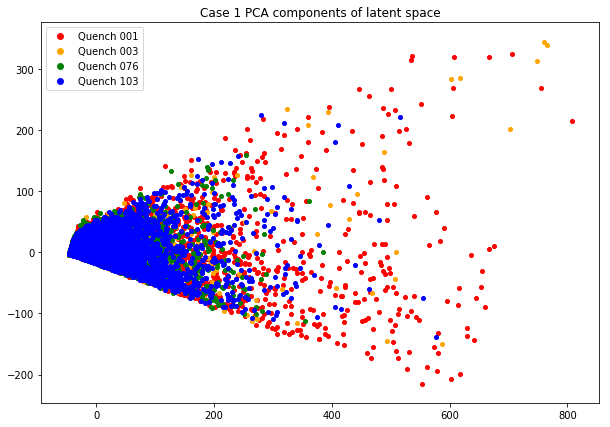

In [28]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

msize = 16

# hack the legend together
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Quench 001',
                          markerfacecolor='red', markersize=8),
                   Line2D([0], [0], marker='o', color='w', label='Quench 003',
                          markerfacecolor='orange', markersize=8),
                   Line2D([0], [0], marker='o', color='w', label='Quench 076',
                          markerfacecolor='green', markersize=8),
                   Line2D([0], [0], marker='o', color='w', label='Quench 103',
                          markerfacecolor='blue', markersize=8)]

# Create the figure and add our hacked legend
plt.figure(figsize=(10, 7))
for i in range(qall_data.shape[0]):
    plt.scatter(img_pca[i,0],img_pca[i,1], s=msize, color=color_label[i])
plt.title('Case 1 PCA components of latent space')
plt.legend(handles=legend_elements)
plt.show()

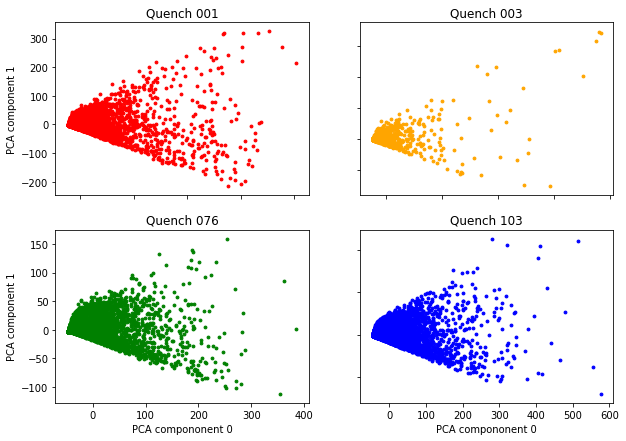

In [29]:
msize = 8

fig, axs = plt.subplots(2, 2)
fig.set_size_inches(10,7)
for i in range(qall_data.shape[0]):
    if color_label[i] == 'red':
        axs[0, 0].scatter(img_pca[i,0],img_pca[i,1], color=color_label[i], s=msize)
        axs[0, 0].set_title('Quench 001')
    elif color_label[i] == 'orange':
        axs[0, 1].scatter(img_pca[i,0],img_pca[i,1], color=color_label[i], s=msize)
        axs[0, 1].set_title('Quench 003')
    elif color_label[i] == 'green':
        axs[1, 0].scatter(img_pca[i,0],img_pca[i,1], color=color_label[i], s=msize)
        axs[1, 0].set_title('Quench 076')
    else:
        axs[1, 1].scatter(img_pca[i,0],img_pca[i,1], color=color_label[i], s=msize)
        axs[1, 1].set_title('Quench 103')

for ax in axs.flat:
    ax.set(xlabel='PCA compononent 0', ylabel='PCA component 1')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

In [9]:
# Finally, try using DBSCAN to directly cluster high-dimensional data!
from sklearn.cluster import DBSCAN
print(encoded.shape)

clustering = DBSCAN(eps=0.1).fit(encoded)
print(clustering.labels_)

(22820, 40)
[-1 -1 -1 ... -1 -1 -1]


In [14]:
from hdbscan import HDBSCAN

clustering = HDBSCAN().fit(encoded)
print(clustering.labels_)

[-1 -1 -1 ... -1 -1 -1]


In [17]:
number_of_minus = 0
number_of_zeros = 0
number_of_42 = 0

for i in range(len(encoded)):
    if clustering.labels_[i] == -1:
        number_of_minus += 1
    elif clustering.labels_[i] == 0:
        number_of_zeros += 1
    elif clustering.labels_[i] == 11:
        number_of_42 += 1

print(number_of_minus + number_of_zeros + number_of_42)
print(number_of_minus)
print(number_of_zeros)
print(number_of_42)

# print(clustering.labels_.tolist())

20742
17914
5
2823


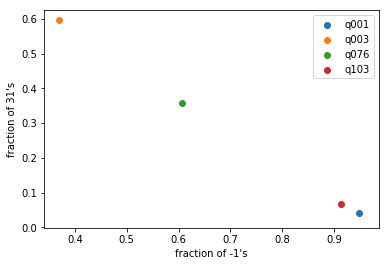

In [20]:
# Interesting results!

q001_minus = 0
q001_42 = 0
q003_minus = 0
q003_42 = 0
q076_minus = 0
q076_42 = 0
q103_minus = 0
q103_42 = 0

for i in range(len(encoded)):
    if i < boundary1:
        if clustering.labels_[i] == -1:
            q001_minus += 1
        elif clustering.labels_[i] == 42:
            q001_42 += 1
    elif i < boundary2:
        if clustering.labels_[i] == -1:
            q003_minus += 1
        elif clustering.labels_[i] == 42:
            q003_42 += 1
    elif i < boundary3:
        if clustering.labels_[i] == -1:
            q076_minus += 1
        elif clustering.labels_[i] == 42:
            q076_42 += 1
    else:
        if clustering.labels_[i] == -1:
            q103_minus += 1
        elif clustering.labels_[i] == 42:
            q103_42 += 1

plt.figure()
plt.scatter([q001_minus / q001_data.shape[0]], [q001_42 / q001_data.shape[0]])
plt.scatter([q003_minus / q003_data.shape[0]], [q003_42 / q003_data.shape[0]])
plt.scatter([q076_minus / q076_data.shape[0]], [q076_42 / q076_data.shape[0]])
plt.scatter([q103_minus / q103_data.shape[0]], [q103_42 / q103_data.shape[0]])
plt.legend(['q001', 'q003', 'q076', 'q103'])
plt.xlabel('fraction of -1\'s')
plt.ylabel('fraction of 31\'s')
plt.show()

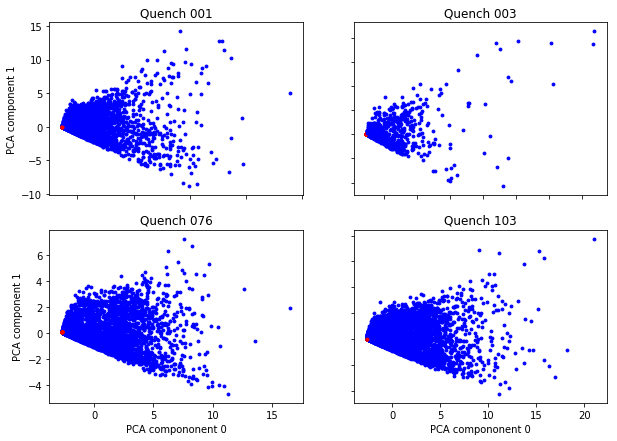

In [22]:
# Plot the PCA to see which clustering a point is correspond to!
msize = 8

fig, axs = plt.subplots(2, 2)
fig.set_size_inches(10,7)
for i in range(qall_data.shape[0]):
    if color_label[i] == 'red':
        if clustering.labels_[i] == -1:
            axs[0, 0].scatter(img_pca[i,0],img_pca[i,1], color='b', s=msize)
        elif clustering.labels_[i] == 42:
            axs[0, 0].scatter(img_pca[i,0],img_pca[i,1], color='r', s=msize)
        else:
            axs[0, 0].scatter(img_pca[i,0],img_pca[i,1], color='g', s=msize)
        axs[0, 0].set_title('Quench 001')
    elif color_label[i] == 'orange':
        if clustering.labels_[i] == -1:
            axs[0, 1].scatter(img_pca[i,0],img_pca[i,1], color='b', s=msize)
        elif clustering.labels_[i] == 42:
            axs[0, 1].scatter(img_pca[i,0],img_pca[i,1], color='r', s=msize)
        else:
            axs[0, 1].scatter(img_pca[i,0],img_pca[i,1], color='g', s=msize)
        axs[0, 1].set_title('Quench 003')
    elif color_label[i] == 'green':
        if clustering.labels_[i] == -1:
            axs[1, 0].scatter(img_pca[i,0],img_pca[i,1], color='b', s=msize)
        elif clustering.labels_[i] == 42:
            axs[1, 0].scatter(img_pca[i,0],img_pca[i,1], color='r', s=msize)
        else:
            axs[1, 0].scatter(img_pca[i,0],img_pca[i,1], color='g', s=msize)
        axs[1, 0].set_title('Quench 076')
    else:
        if clustering.labels_[i] == -1:
            axs[1, 1].scatter(img_pca[i,0],img_pca[i,1], color='b', s=msize)
        elif clustering.labels_[i] == 42:
            axs[1, 1].scatter(img_pca[i,0],img_pca[i,1], color='r', s=msize)
        else:
            axs[1, 1].scatter(img_pca[i,0],img_pca[i,1], color='g', s=msize)
        axs[1, 1].set_title('Quench 103')

for ax in axs.flat:
    ax.set(xlabel='PCA compononent 0', ylabel='PCA component 1')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

(5705, 2000, 1)
(22820, 2000, 1)
[8962, 15464, 4486]


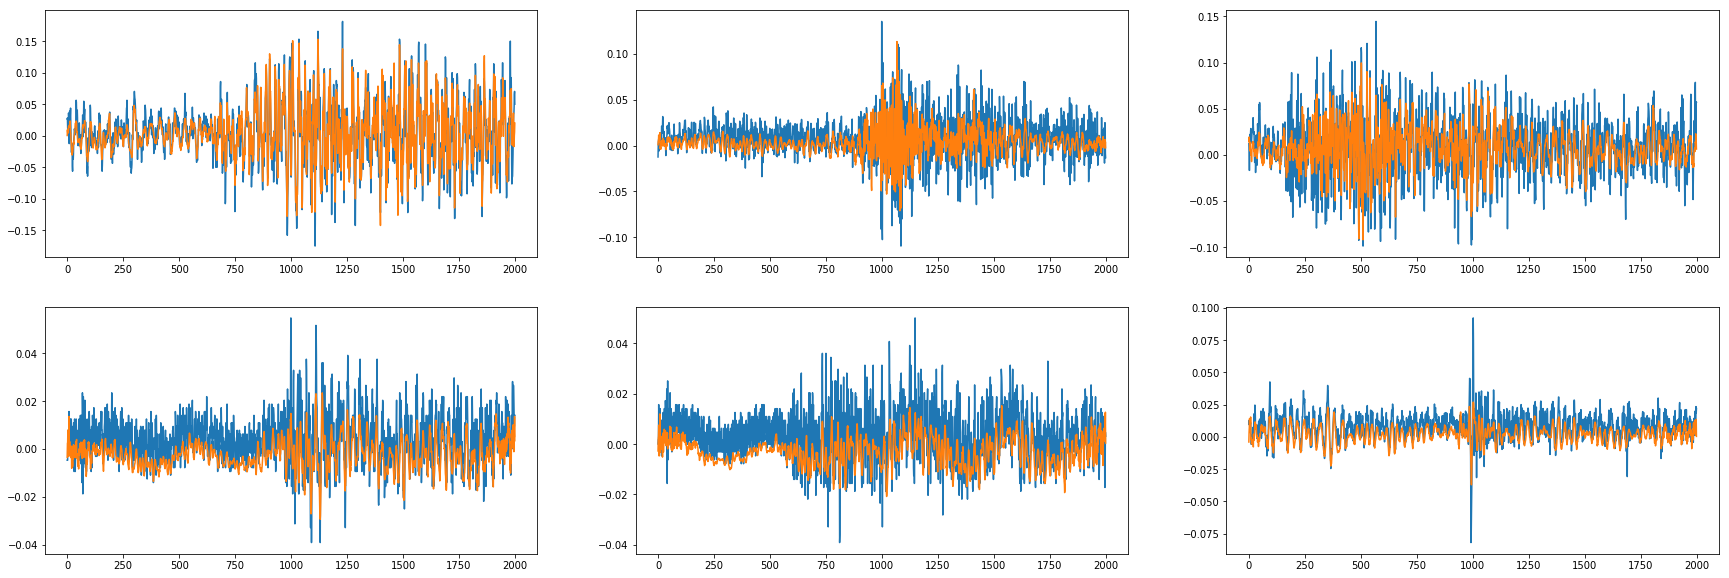

In [20]:
# Try to plot what class-1 and class31 correspond to
num_images = 3
class_minus = []
class_232 = []

for _ in range(qall_data.shape[0]):
    if len(class_minus) == num_images and len(class_232) == num_images:
        break
    
    random_image = np.random.randint(qall_data.shape[0], size = 1)
    if clustering.labels_[random_image[0]] == -1 and len(class_minus) < num_images:
        class_minus.append(random_image[0])
    elif clustering.labels_[random_image[0]] == 11 and len(class_232) < num_images:
        class_232.append(random_image[0])

encoded_imgs = encoder.predict(data_mod)
decoded_imgs = autoencoder.predict(data_mod)

print(x_test.shape)
print(decoded_imgs.shape)
print(class_232)

plt.figure(figsize=(30, 10))
#scalograms are 256 by 512

for i in range(3):
    # plot original image
    ax = plt.subplot(2, num_images, i + 1)
    plt.plot(data_mod[class_minus[i], :, 0])
    plt.plot(decoded_imgs[class_minus[i], :, 0])
    
    # plot encoded image
#     ax = plt.subplot(3, num_images, num_images + i + 1)
#     plt.imshow(encoded_imgs[image_idx, :, 256].reshape(8, 5))
#     plt.gray()
#     ax.get_xaxis().set_visible(False)
#     ax.get_yaxis().set_visible(False)
#     plt.axis('equal')

    ax = plt.subplot(2, num_images, num_images + i + 1)
    plt.plot(data_mod[class_232[i], :, 0])
    plt.plot(decoded_imgs[class_232[i], :, 0])

plt.show()